In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import random

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))
PNG_PATH = '../saves/png'
os.makedirs(name=PNG_PATH, exist_ok=True)


# Visualize every DM/Patient Interaction

In [3]:

# Get all CSVs out of one data frame
if nu.pickle_exists('clean_csvs_df'):
    clean_csvs_df = nu.load_object('clean_csvs_df')
    print(clean_csvs_df.shape)
    df = clean_csvs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(149166, 100)


,6987,5821,76495,41101
action_type,INJURY_RECORD,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER
elapsed_time,625355,3643477,523637,974314
event_time,2023-05-12 17:00:00,2023-05-16 15:59:00,2023-06-23 10:06:00,2023-03-08 10:54:00
session_uuid,0b891add-e0c3-463d-948d-7f491f1d10ef,06574b6f-ab02-432c-9a65-7b031218a270,7de52180-d823-4f9e-9003-aeab8139970b,89c48e7e-780f-4f1b-a846-fc0f4fd9841c
file_name,0b891add-e0c3-463d-948d-7f491f1d10ef,06574b6f-ab02-432c-9a65-7b031218a270,7de52180-d823-4f9e-9003-aeab8139970b,Marty24
scene_index,4,12,2,2
injury_record_id,L Thigh Laceration,NaN,NaN,NaN
injury_record_patient_id,Lily_0 Root,NaN,NaN,NaN
injury_record_required_procedure,tourniquet,NaN,NaN,NaN
injury_record_severity,medium,NaN,NaN,NaN



#### Visualize the decision points on one patient's timeline

In [4]:

# from pandas import Timedelta

def show_timeline(random_session_uuid=None, random_time_group=None, random_patient_id=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        random_session_uuid = random.choice(clean_csvs_df.session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (clean_csvs_df.session_uuid == random_session_uuid)
        random_time_group = random.choice(clean_csvs_df[mask_series].scene_index.unique())
    
    # Get a random patient from within the scene
    base_mask_series = (clean_csvs_df.session_uuid == random_session_uuid) & (clean_csvs_df.scene_index == random_time_group)
    if random_patient_id is None:
        random_patient_id = random.choice(clean_csvs_df[base_mask_series].patient_id.unique())
    
    # Get the event time and elapsed time of the person engaged
    mask_series = base_mask_series & (clean_csvs_df.patient_id == random_patient_id)
    mask_series &= clean_csvs_df.action_type.isin([
        'PATIENT_ENGAGED', 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
    ])
    columns_list = ['elapsed_time', 'event_time']
    patient_engagements_df = clean_csvs_df[mask_series][columns_list].sort_values(['elapsed_time'])
    if verbose: display(patient_engagements_df)
    if patient_engagements_df.shape[0]:
        
        # For the patient, get a timeline of every reference on or before engagement
        hlineys_list = []; hlinexmins_list = []; hlinexmaxs_list = []; hlinecolors_list = []; hlinelabels_list = []
        hlineaction_types_list = []; vlinexs_list = []
        left_lim = 999999; right_lim = -999999
        
        # Get the broad horizontal line parameters
        hlineys_list.append(0)
        hlinecolors_list.append(plt.cm.Accent(0))
        hlinelabels_list.append(random_patient_id)
        
        # Create the filter
        mask_series = base_mask_series & (clean_csvs_df.patient_id == random_patient_id)
        elapsed_time = patient_engagements_df.elapsed_time.max()
        mask_series &= (clean_csvs_df.elapsed_time <= elapsed_time)
        # event_time_start = patient_engagements_df.event_time.min() - Timedelta(minutes=5)
        # event_time_stop = patient_engagements_df.event_time.max()
        # mask_series &= (clean_csvs_df.event_time >= event_time_start)
        
        df1 = clean_csvs_df[mask_series].sort_values(['elapsed_time'])
        if verbose: display(df1)
        if df1.shape[0]:
            
            # Get the fine horizontal line parameters and plot dimensions
            xmin = df1.elapsed_time.min(); hlinexmins_list.append(xmin);
            if xmin < left_lim: left_lim = xmin
            xmax = df1.elapsed_time.max(); hlinexmaxs_list.append(xmax);
            if xmax > right_lim: right_lim = xmax
            
            # Get the vertical line parameters
            mask_series = df1.action_type.isin(['SESSION_END', 'SESSION_START'])
            for x in df1[mask_series].elapsed_time:
                vlinexs_list.append(x)
            
            # Get the action type annotation parameters
            y = 0
            mask_series = df1.action_type.isin(['INJURY_TREATED', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'])
            for label, df2 in df1[mask_series].groupby('action_type'):
                for x in df2.elapsed_time:
                    annotation_tuple = (label.lower().replace('_', ' '), x, y)
                    hlineaction_types_list.append(annotation_tuple)
            
            ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
            
            # Add the timelines to the figure subplot axis
            if verbose: print(hlineys_list, hlinexmins_list, hlinexmaxs_list, hlinecolors_list)
            line_collection_obj = ax.hlines(hlineys_list, hlinexmins_list, hlinexmaxs_list, colors=hlinecolors_list)
            
            # Label each timeline with the appropriate patient name
            for label, x, y in zip(hlinelabels_list, hlinexmins_list, hlineys_list):
                plt.annotate(label.replace(' Root', ''), (x, y), textcoords='offset points', xytext=(0, -8), ha='left')
            
            # Annotate the action types along their timeline
            for annotation_tuple in hlineaction_types_list:
                label, x, y = annotation_tuple
                plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, 0), va='center', rotation=90, fontsize=6)
            
            # Mark any session boundaries with a vertical line
            ymin, ymax = ax.get_ylim()
            line_collection_obj = ax.vlines(vlinexs_list, ymin=ymin, ymax=ymax)
            
            # Remove the ticks and tick labels from the y axis
            ax.set_yticks([])
            ax.set_yticklabels([])
            
            # Move the top and right border out so that the annotations don't cross it
            # plt.subplots_adjust(top=1.5)
            # xlim_tuple = ax.set_xlim(left_lim, right_lim+10_000)
            
            # Set the title and labels
            patient_name = random_patient_id.replace(' Root', '')
            ax.set_title(f'Patient {patient_name} Timeline for UUID {random_session_uuid} and Scene {random_time_group}')
            ax.set_xlabel('Elapsed Time since Scene Start')

    return random_session_uuid, random_time_group, random_patient_id

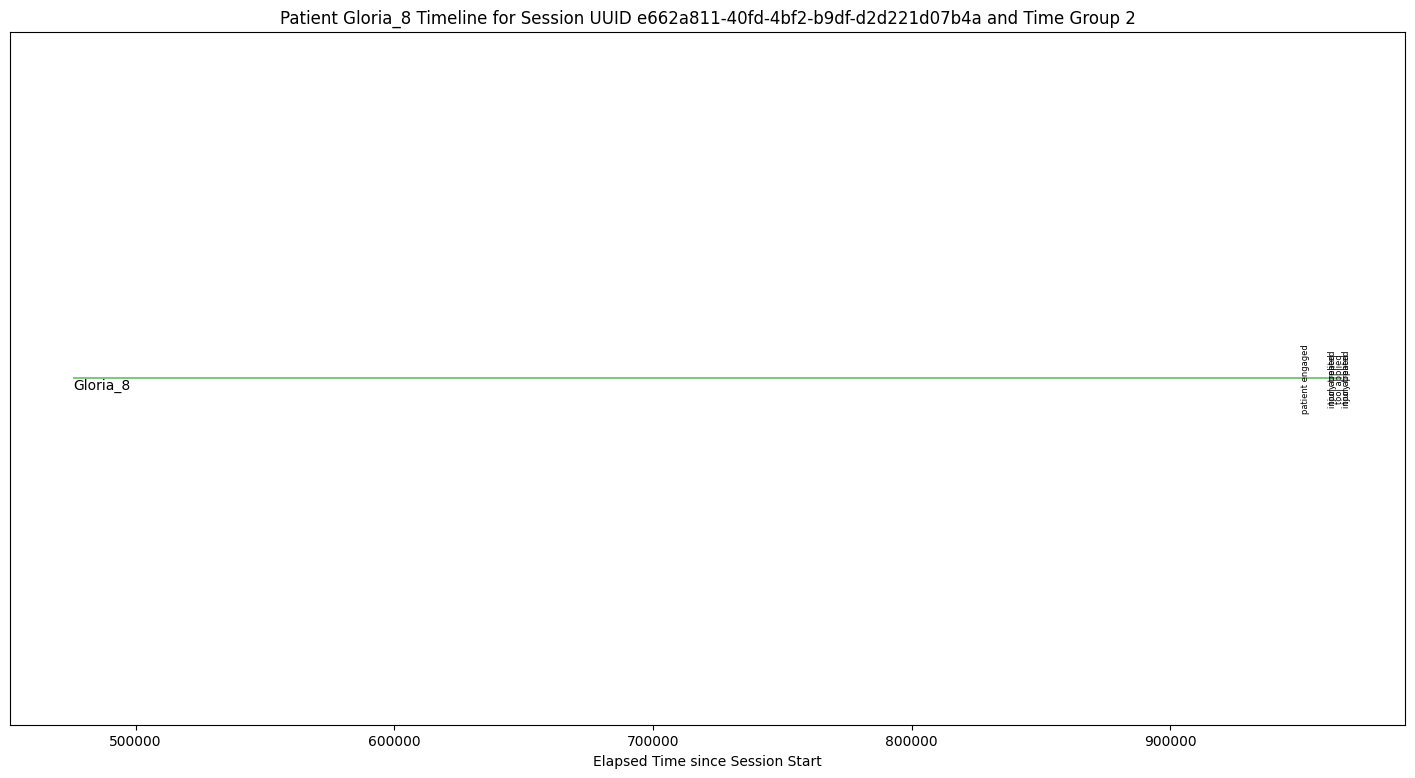

In [11]:

%matplotlib inline

random_session_uuid, random_time_group, random_patient_id = show_timeline('e662a811-40fd-4bf2-b9df-d2d221d07b4a', 2, 'Gloria_8 Root', verbose=False)

In [27]:

def store_timelines(random_session_uuid=None, random_time_group=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        random_session_uuid = random.choice(clean_csvs_df.session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (clean_csvs_df.session_uuid == random_session_uuid)
        random_time_group = random.choice(clean_csvs_df[mask_series].scene_index.unique())
    
    file_path = os.path.join(PNG_PATH, f'{random_session_uuid}_{random_time_group}.png')
    if not os.path.exists(file_path):
        
        # Get the event time and elapsed time of each person engaged
        base_mask_series = (clean_csvs_df.session_uuid == random_session_uuid) & (clean_csvs_df.scene_index == random_time_group)
        mask_series = base_mask_series & clean_csvs_df.action_type.isin([
            'PATIENT_ENGAGED', 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
        ])
        columns_list = ['patient_id', 'elapsed_time']
        patient_engagements_df = clean_csvs_df[mask_series][columns_list].sort_values(['elapsed_time'])
        if verbose: display(patient_engagements_df)
        
        # For each patient, get a timeline of every reference on or before engagement
        color_cycler = nu.get_color_cycler(len(patient_engagements_df.patient_id.unique()))
        hlineys_list = []; hlinexmins_list = []; hlinexmaxs_list = []; hlinecolors_list = []; hlinelabels_list = []
        hlineaction_types_list = []; vlinexs_list = []
        left_lim = 999999; right_lim = -999999
        for (patient_id, df), (y, face_color_dict) in zip(patient_engagements_df.groupby('patient_id'), enumerate(color_cycler())):
        
            # Get the broad horizontal line parameters
            hlineys_list.append(y)
            face_color = face_color_dict['color']
            hlinecolors_list.append(face_color)
            hlinelabels_list.append(patient_id)
        
            # Create the filter for the first scene
            mask_series = base_mask_series & (clean_csvs_df.patient_id == patient_id)
            elapsed_time = df.elapsed_time.max()
            mask_series &= (clean_csvs_df.elapsed_time <= elapsed_time)
            
            df1 = clean_csvs_df[mask_series].sort_values(['elapsed_time'])
        
            # Get the fine horizontal line parameters and plot dimensions
            xmin = df1.elapsed_time.min(); hlinexmins_list.append(xmin);
            if xmin < left_lim: left_lim = xmin
            xmax = df1.elapsed_time.max(); hlinexmaxs_list.append(xmax);
            if xmax > right_lim: right_lim = xmax
            
            # Get the vertical line parameters
            mask_series = df1.action_type.isin(['SESSION_END', 'SESSION_START'])
            for x in df1[mask_series].elapsed_time:
                vlinexs_list.append(x)
            
            # Get the action type annotation parameters
            mask_series = df1.action_type.isin(['INJURY_TREATED', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'])
            for label, df2 in df1[mask_series].groupby('action_type'):
                for x in df2.elapsed_time:
                    annotation_tuple = (label.lower().replace('_', ' '), x, y)
                    hlineaction_types_list.append(annotation_tuple)
        
        plt.ioff()
        ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
        
        # Add the timelines to the figure subplot axis
        line_collection_obj = ax.hlines(hlineys_list, hlinexmins_list, hlinexmaxs_list, colors=hlinecolors_list)
        
        # Label each timeline with the appropriate patient name
        for label, x, y in zip(hlinelabels_list, hlinexmins_list, hlineys_list):
            plt.annotate(label.replace(' Root', ''), (x, y), textcoords='offset points', xytext=(0, -8), ha='left')
        
        # Annotate the action types along their timeline
        for annotation_tuple in hlineaction_types_list:
            label, x, y = annotation_tuple
            plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, 0), va='center', rotation=90, fontsize=6)
        
        # Mark any session boundaries with a vertical line
        ymin, ymax = ax.get_ylim()
        line_collection_obj = ax.vlines(vlinexs_list, ymin=ymin, ymax=ymax)
        
        # Remove the ticks and tick labels from the y axis
        ax.set_yticks([])
        ax.set_yticklabels([])
        
        # Move the top and right border out so that the annotations don't cross it
        plt.subplots_adjust(top=1.5)
        xlim_tuple = ax.set_xlim(left_lim-10_000, right_lim+10_000)
        
        # Set the title and labels
        ax.set_title(f'Multi-Patient Timeline for UUID {random_session_uuid} and Scene {random_time_group}')
        ax.set_xlabel('Elapsed Time since Scene Start')
    
        # Save the figure to PNG
        plt.savefig(file_path, bbox_inches='tight')
        plt.ion()

In [28]:

for (session_uuid, scene_index), df in nu.get_session_groupby(mask_series=None, extra_column='scene_index'):
    store_timelines(random_session_uuid=session_uuid, random_time_group=scene_index, verbose=False)

In [22]:

def store_teleportations(random_session_uuid=None, random_time_group=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        random_session_uuid = random.choice(clean_csvs_df.session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (clean_csvs_df.session_uuid == random_session_uuid)
        random_time_group = random.choice(clean_csvs_df[mask_series].scene_index.unique())
    
    file_path = os.path.join(PNG_PATH, f'teleportations_{random_session_uuid}_{random_time_group}.png')
    if not os.path.exists(file_path):
        
        # Get the event time and elapsed time of each person engaged
        base_mask_series = (clean_csvs_df.session_uuid == random_session_uuid) & (clean_csvs_df.scene_index == random_time_group)
        plt.ioff()
        ax = plt.figure(figsize=(18, 9)).add_subplot()
        
        # Show the positions of patients recorded and engaged at our scene and session UUID
        color_cycler = nu.get_color_cycler(clean_csvs_df[base_mask_series].groupby('patient_id').size().shape[0])
        location_cns_list = ['patient_record_position', 'patient_engaged_position']
        for ((session_uuid, patient_id), df1), face_color_dict in zip(clean_csvs_df[base_mask_series].sort_values([
            'elapsed_time'
        ]).groupby(['session_uuid', 'patient_id']), color_cycler()):
            x = []; y = []; z = []
            for location_cn in location_cns_list:
                mask_series = df1[location_cn].isnull()
                srs = df1[~mask_series][location_cn].map(lambda x: eval(x))
                x.extend(srs.map(lambda x: x[0]).values)
                y.extend(srs.map(lambda x: x[1]).values)
                z.extend(srs.map(lambda x: x[2]).values)
            face_color = face_color_dict['color']
            # if verbose: display(df1.dropna(axis='columns', how='all').T)
            columns_list = [cn for cn in df1.columns if cn.endswith('_sort')]
            sort_df = df1[columns_list].dropna(axis='columns', how='all').dropna(axis='index', how='all')
            if sort_df.shape[0]:
                sort_df = sort_df.iloc[-1]
                # if verbose: print(patient_id)
                # if verbose: display(sort_df.mode())
                label = patient_id.replace(' Root', ' (') + sort_df.mode().squeeze() + ')'
                if verbose: print(label)
                ax.plot(x, z, c=face_color, alpha=1.0, label=label)
                ax.scatter(x, z, c=face_color, alpha=1.0)
                coords_set = set()
                for x, z in zip(x, z):
                    coords_tuple = (x, z)
                    coords_set.add(coords_tuple)
                for coords_tuple in coords_set:
                    x, y = coords_tuple
                    plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, -8), ha='center', va='center')
                    break
        
        # Visualize non-cumulative teleportations
        x = []; z = []
        mask_series = (clean_csvs_df.action_type == 'TELEPORT') & base_mask_series
        teleports_df = clean_csvs_df[mask_series].sort_values(['elapsed_time'])
        for teleport_location in teleports_df.teleport_location:
            teleport_location = eval(teleport_location)
            x.append(teleport_location[0])
            z.append(teleport_location[2])
        ax.plot(x, z, alpha=1.0, label='teleportations');
        
        # Add legend and labels
        ax.set_title(f'Teleportation Map for UUID {random_session_uuid} and Scene {random_time_group}')
        ax.legend()
        ax.set_xlabel('X')
        ax.set_ylabel('Z');
    
        # Save the figure to PNG
        plt.savefig(file_path, bbox_inches='tight')
        plt.ion()

In [24]:

for (session_uuid, scene_index), df in nu.get_session_groupby(mask_series=None, extra_column='scene_index'):
    store_teleportations(random_session_uuid=session_uuid, random_time_group=scene_index, verbose=False)